In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits
from sklearn.decomposition import FastICA
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import cv2

In [2]:
in_path_fg = "./foregrounds/FastICA_Data/"
in_path_cs = "./foregrounds/FastICA_Data/"

output_path = "./foregrounds/FastICA_Data/"
fname_all = "test_filename"


fname_foreground = "foregrounds_total"
fname_cs = "observer_lightcone"
fname_noise = "noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K"


indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits')

indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')
indata_cs = indata_cs/1000 # 21cmFAST are in mK by default, convert to K

indata_noise = fits.getdata(in_path_cs+fname_noise+'.fits')
indata_noise = indata_noise[:316, :, :]
arr = np.zeros((316,150,150))
for i in range(316):
    arr[i,:,:] = cv2.resize((indata_noise[i,:,:]-np.min(indata_noise[i,:,:])), (150, 150))+np.min(indata_noise[i,:,:])



indata_fg = indata_fg.transpose(2, 0, 1)
indata_cs = indata_cs.transpose(2, 0, 1)
indata_noise = arr
    

sh = indata_fg.shape
print(sh)
print(np.shape(arr))

(316, 150, 150)
(316, 150, 150)


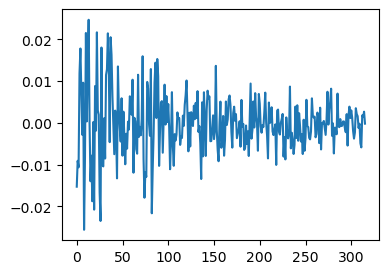

In [8]:
plt.figure(figsize=(9,3))
plt.subplot(122)
plt.plot((indata_noise[:,40,40]))


-0.09347645473374737
-0.07960116878149033


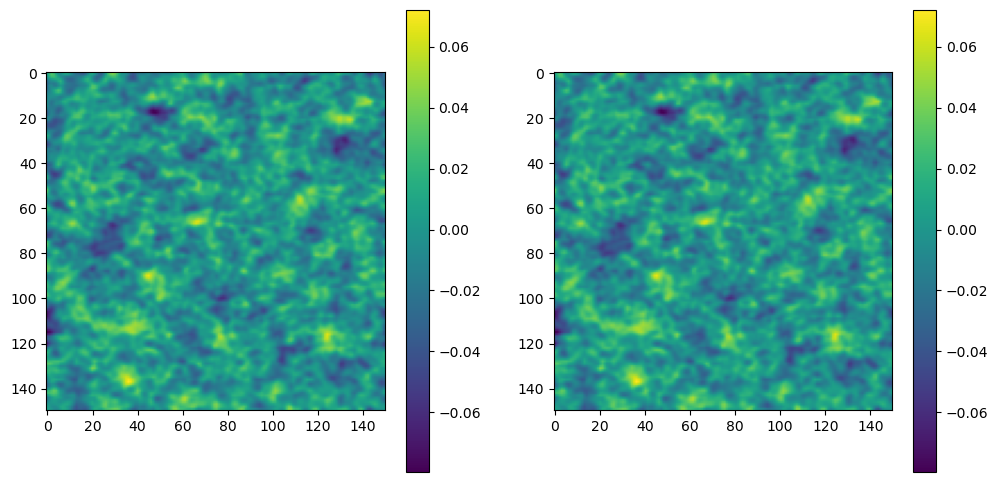

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(arr[0,:,:])
plt.colorbar()

plt.subplot(122)
plt.imshow((indata_noise[0,:,:]))
plt.colorbar()

print(np.min(arr))
print(np.min(indata_noise[0,:,:]))

In [4]:
ncomp = 4

indata = indata_fg + indata_cs + indata_noise

sh = indata.shape
print(sh)
X = np.reshape(indata,(sh[0], sh[1]*sh[2]))

ica1 = FastICA(n_components=ncomp)
model1 = []
S = ica1.fit_transform(X.T)  # Reconstruct signals
A = ica1.mixing_  # Get estimated mixing matrix

model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))

res =  indata-model1


rec =  indata-res

(316, 150, 150)


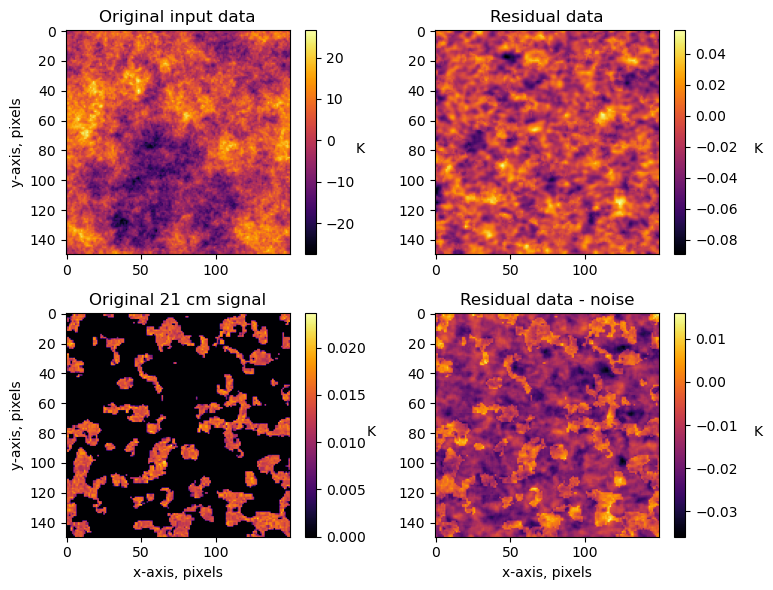

In [5]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.imshow(indata[0], cmap='inferno')
plt.title('Original input data')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0)
plt.ylabel('y-axis, pixels')

plt.subplot(222)
plt.imshow(res[0], cmap='inferno')
plt.title('Residual data')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0, labelpad=15)

plt.subplot(223)
plt.imshow(indata_cs[0], cmap='inferno')
plt.title('Original 21 cm signal')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0)
plt.xlabel('x-axis, pixels')
plt.ylabel('y-axis, pixels')

plt.subplot(224)
plt.imshow(res[0]-indata_noise[0], cmap='inferno')
plt.title('Residual data - noise')
cbar = plt.colorbar()
cbar.set_label('K', rotation=0, labelpad=15)
plt.xlabel('x-axis, pixels')

plt.tight_layout()

/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


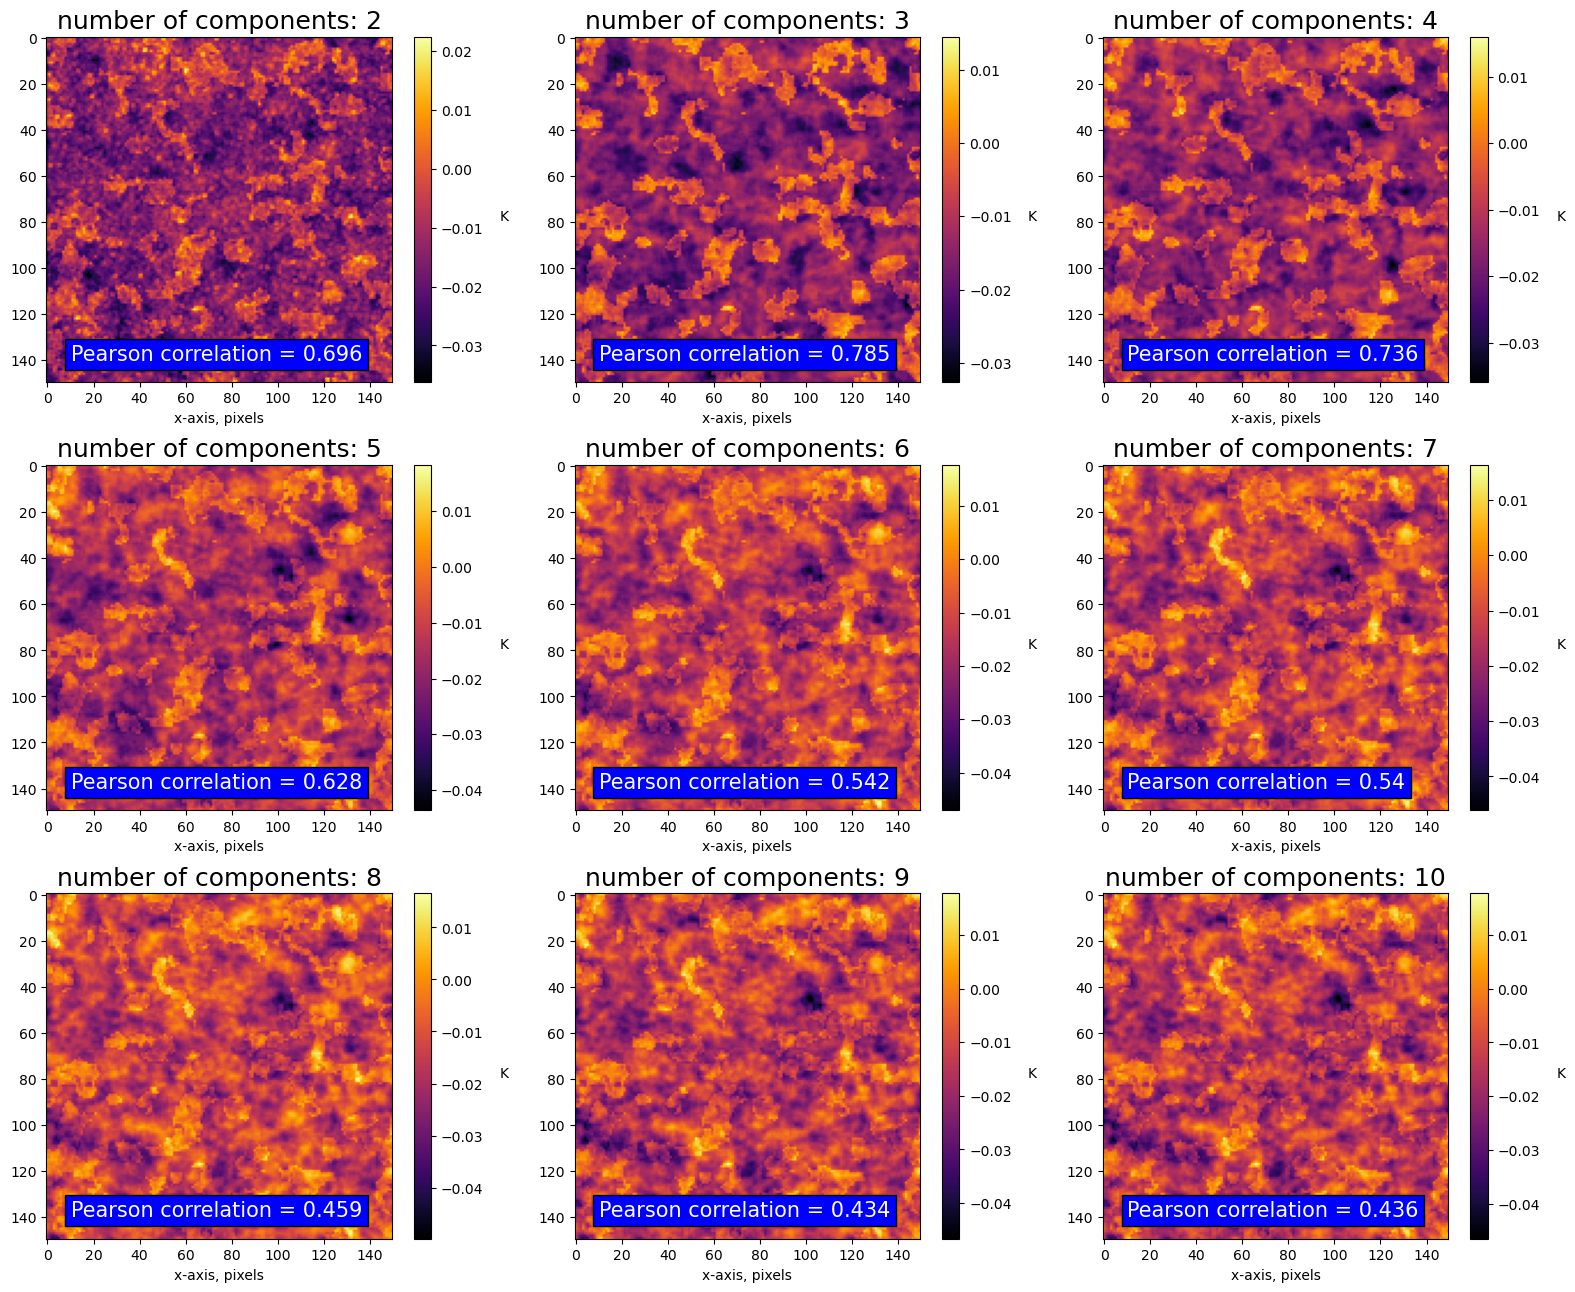

In [6]:
plt.figure(figsize=(16,13))

for ncomp in range(2,11):
    
    ica1 = FastICA(n_components=ncomp)
    model1 = []
    S = ica1.fit_transform(X.T)  # Reconstruct signals
    A = ica1.mixing_  # Get estimated mixing matrix

    model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))

    res =  indata-model1
    
    reconstruction = res[0]-indata_noise[0]
    # Structural similarity index
    #sim_index = ssim(indata_cs[0], reconstruction, data_range=-reconstruction.max() + reconstruction.min() ,multichannel=False)

    corr, _ = pearsonr(indata_cs[0].flatten(), reconstruction.flatten())

    plt.subplot(3,3,ncomp-1)
    plt.imshow(res[0]-indata_noise[0], cmap='inferno')
    plt.title('number of components: {}'.format(ncomp), fontsize=18)
    plt.text(10, 140, 'Pearson correlation = {}'.format(round(corr,3)), fontsize=15, color='white', 
         bbox=dict(facecolor='blue', alpha=1.0))
    cbar = plt.colorbar()
    cbar.set_label('K', rotation=0, labelpad=15)
    plt.xlabel('x-axis, pixels')
    
plt.tight_layout()
plt.show()
    

# Power spectrum

In [7]:
import tools21cm as tc

In [8]:
ica1 = FastICA(n_components=3) # 3 deduced to be the best from previous cells
model1 = []
S = ica1.fit_transform(X.T)  # Reconstruct signals
A = ica1.mixing_  # Get estimated mixing matrix

model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))



In [9]:
res =  indata-model1
noise = np.copy(indata_noise)
cosm = np.copy(indata_cs)

P_res, k_res, n_res = tc.power_spectrum_1d(res, kbins=10, box_dims=500, return_n_modes=True)
P_noise, k_noise, n_noise = tc.power_spectrum_1d(noise, kbins=10, box_dims=500, return_n_modes=True)
P_cosm, k_cosm, n_cosm = tc.power_spectrum_1d(cosm, kbins=10, box_dims=500, return_n_modes=True)

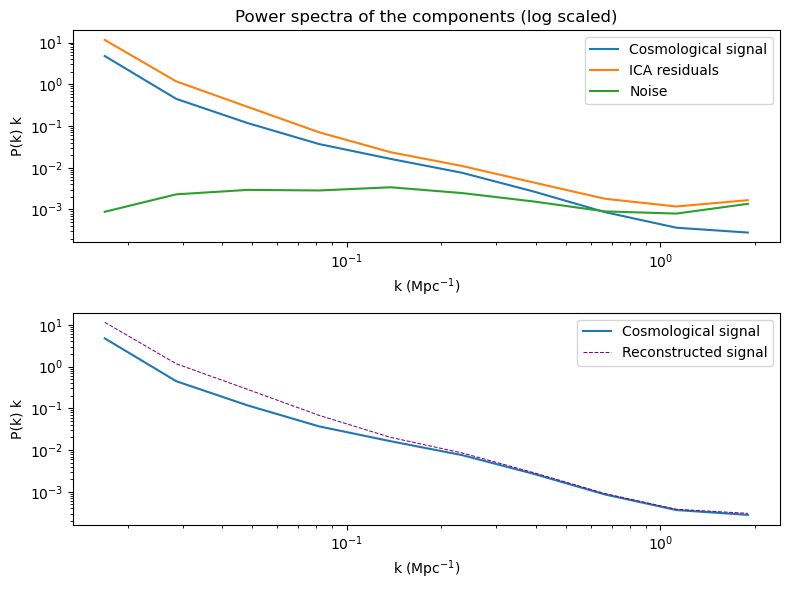

In [10]:
plt.figure(figsize = (8,6))
plt.subplot(211)
plt.title('Power spectra of the components (log scaled)')
plt.loglog(k_cosm, P_cosm*k_cosm, label='Cosmological signal')
plt.loglog(k_res, P_res*k_res, label='ICA residuals')
plt.loglog(k_noise, P_noise*k_noise, label='Noise')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k')
plt.legend()

P_rec = P_res - P_noise

plt.subplot(212)
plt.loglog(k_cosm, P_cosm*k_cosm, label='Cosmological signal')
plt.loglog(k_res, P_rec*k_res,'--',color='purple', linewidth=0.75,label='Reconstructed signal')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k')
plt.legend()

plt.tight_layout()

In [11]:
np.shape(indata_cs)

(316, 150, 150)

In [12]:
nu_min = 1420/(1+13.0)
nu_max = 1420/(1+8.0)

(nu_max-nu_min)/8 #amount of 8 MHz slices

7.043650793650793

In [13]:
int(316/7.043650793650793) #amount of pixels per slice

44

In [14]:
slices_cs = []
slices_fg = []
slices_noise = []



lb = 0
hb = 43

for i in range(7):

    slices_cs.append(indata_cs[lb:hb, :, :])
    slices_fg.append(indata_fg[lb:hb, :, :])
    slices_noise.append(indata_noise[lb:hb, :, :])
    lb += 44
    hb += 44

In [15]:
for i in range(len(slices_fg)):
    print(np.shape(slices_fg[i]))

(43, 150, 150)
(43, 150, 150)
(43, 150, 150)
(43, 150, 150)
(43, 150, 150)
(43, 150, 150)
(43, 150, 150)


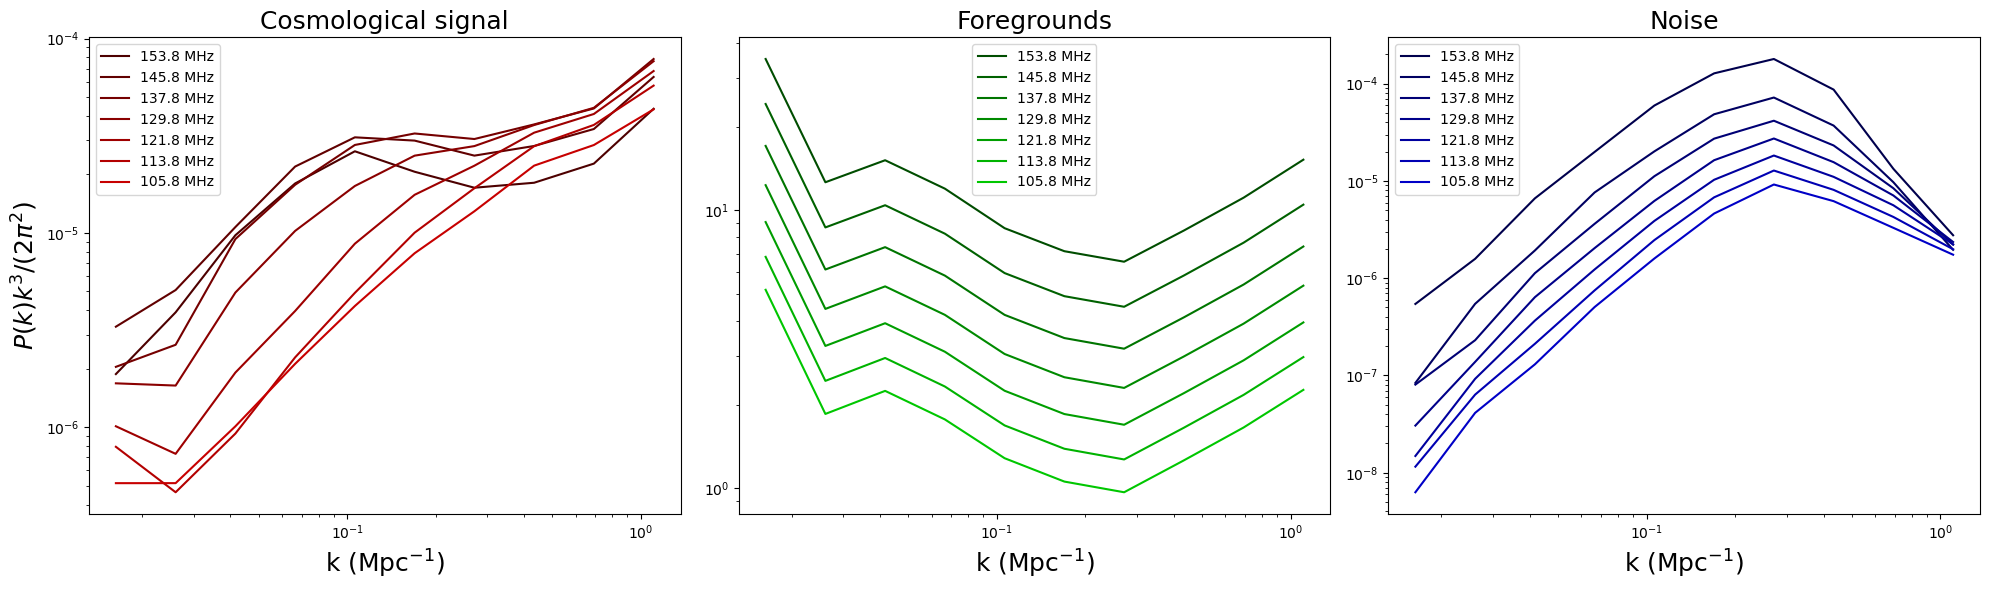

In [16]:
fig = plt.figure(figsize=(20,6))
#plt.suptitle('Spherically averaged power spectra', fontsize=24)

slices = [slices_cs, slices_fg, slices_noise]
titles = ['Cosmological signal', 'Foregrounds', 'Noise']

nu_min = 1420/(1+13.0)
nu_max = 1420/(1+8.0)

clr_idx = [1,0,0]

for i in range(3):

    ax = fig.add_subplot(1,3,i+1)
    
    for j in range(7):


        P, k = tc.power_spectrum_1d(slices[i][j], kbins=10, box_dims=500)
        ax.loglog(k, P*k**3*(2*np.pi**2)**(-1) , color=(clr_idx[0]*(0.3+0.08*j),clr_idx[1]*(0.3+0.08*j),clr_idx[2]*(0.3+0.08*j)),\
                   label='{} MHz'.format(round((nu_max-4)-8*(j),1)))
        

    plt.xlabel('k (Mpc$^{-1}$)', fontsize=18)
    if i==0:
        plt.ylabel(r'$P(k) k^3/(2 \pi^2)$', fontsize=18)
    plt.title(titles[i], fontsize=18)
    plt.legend(fontsize=10)

    clr_idx[i]=0
    if i!= 2:
        clr_idx[i+1]=1
plt.tight_layout()

In [17]:
res =  indata-model1
noise = np.copy(indata_noise)
cosm = np.copy(indata_cs)

P_res, k_res, n_res = tc.power_spectrum_1d(res[:, :, :], kbins=13, box_dims=500, return_n_modes=True)
P_noise, k_noise, n_noise = tc.power_spectrum_1d(noise[:, :, :], kbins=13, box_dims=500, return_n_modes=True)
P_cosm, k_cosm, n_cosm = tc.power_spectrum_1d(cosm[:, :, :], kbins=13, box_dims=500, return_n_modes=True)



In [26]:
sigma_cosm = P_cosm/np.sqrt(n_cosm)
sigma_noise = P_noise/np.sqrt(n_noise)
sigma_res = P_res/np.sqrt(n_res)

sigma_ln_cosm = sigma_cosm/(P_cosm)
sigma_ln_noise = sigma_noise/(P_noise)
sigma_ln_res = sigma_res/(P_res)

sigma_ln_cosm1 = sigma_cosm/np.log(P_cosm)
sigma_ln_noise1 = sigma_noise/np.log(P_noise)
sigma_ln_res1 = sigma_res/np.log(P_res)

"y_upper = [y_val + err_val for y_val, err_val in zip(np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), sigma_ln_res)]\ny_lower = [y_val - err_val for y_val, err_val in zip(np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), sigma_ln_res)]\n\nplt.figure()\nplt.plot(np.log(k_res), np.log(P_res*k_res**3*(2*np.pi**2)**(-1)))\nplt.fill_between(np.log(k_res), y_lower, y_upper, color='gray', alpha=0.2, label='Error region')\nplt.errorbar(np.log(k_res), np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), yerr=sigma_ln_res,color='purple', fmt='.', capsize=3)"

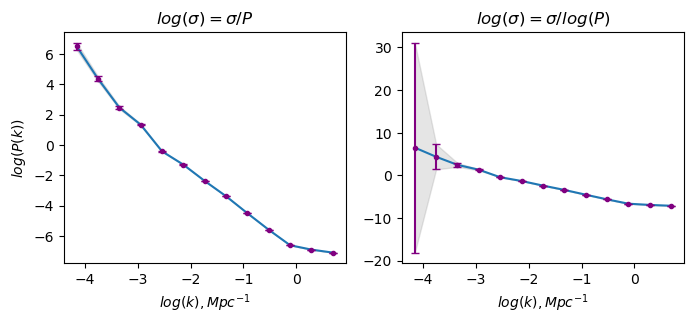

In [33]:
y_upper = [y_val + err_val for y_val, err_val in zip(np.log(P_res), sigma_ln_res)]
y_lower = [y_val - err_val for y_val, err_val in zip(np.log(P_res), sigma_ln_res)]

y_upper1 = [y_val + err_val for y_val, err_val in zip(np.log(P_res), sigma_ln_res1)]
y_lower1 = [y_val - err_val for y_val, err_val in zip(np.log(P_res), sigma_ln_res1)]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.log(k_res), np.log(P_res))
plt.fill_between(np.log(k_res), y_lower, y_upper, color='gray', alpha=0.2, label='Error region')
plt.errorbar(np.log(k_res), np.log(P_res), yerr=abs(sigma_ln_res),color='purple', fmt='.', capsize=3)
plt.xlabel(r'$log(k), Mpc^{-1}$')
plt.ylabel(r'$log(P(k))$')
plt.title(r'$log(\sigma) = \sigma/P$')
plt.subplot(122)
plt.plot(np.log(k_res), np.log(P_res))
plt.fill_between(np.log(k_res), y_lower1, y_upper1, color='gray', alpha=0.2, label='Error region')
plt.errorbar(np.log(k_res), np.log(P_res), yerr=abs(sigma_ln_res1),color='purple', fmt='.', capsize=3)
plt.xlabel(r'$log(k), Mpc^{-1}$')
plt.title(r'$log(\sigma) = \sigma/log(P)$')

'''y_upper = [y_val + err_val for y_val, err_val in zip(np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), sigma_ln_res)]
y_lower = [y_val - err_val for y_val, err_val in zip(np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), sigma_ln_res)]

plt.figure()
plt.plot(np.log(k_res), np.log(P_res*k_res**3*(2*np.pi**2)**(-1)))
plt.fill_between(np.log(k_res), y_lower, y_upper, color='gray', alpha=0.2, label='Error region')
plt.errorbar(np.log(k_res), np.log(P_res*k_res**3*(2*np.pi**2)**(-1)), yerr=sigma_ln_res,color='purple', fmt='.', capsize=3)'''




